In [57]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",          
    password="12345",
    database="Ecomarce",
    use_pure=True         
)

cur = db.cursor()         

print("Connected successfully!")


Connected successfully!


# List all unique cities where customers are located.

In [13]:
query="""  select distinct customer_city 
        from customers """ 
cur.execute(query)
data=cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017.

In [17]:
query="""select count(order_id)   from orders where year(order_purchase_timestamp)=2017  """
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are :", data[0][0]

('total orders placed in 2017 are :', 45101)

#  Find the total sales per category.

In [71]:
query=""" select products.product_category ,round(sum(payments.payment_value),2) as Total_Sales
from products join order_items on products.product_id=order_items.product_id 
join payments on payments.order_id=order_items.order_id 
group by products.product_category """
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["Category","Total_Sales"])
df.head()


,Category,Total_Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


#  Calculate the percentage of orders that were paid in installments.

In [30]:
query="""select (sum(case when payment_installments > 0 then 1 else 0 end )/count(*)) * 100 
from payments   """
cur.execute(query)
data=cur.fetchall()
"% of Orders that paid in installments  :",  data[0][0]

('% of Orders that paid in installments  :', Decimal('99.9981'))

# Count the number of customers from each state.

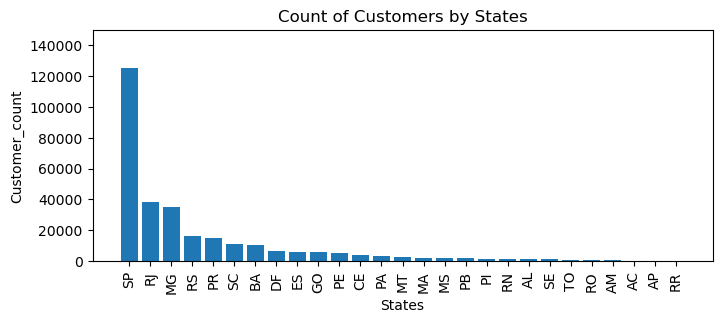

In [43]:
query="""select customer_state,count(customer_id)
 from customers
 group by customer_state
 order by  count(customer_id) desc   """
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["State","Customer_count"])

plt.figure(figsize = (8,3))
plt.bar(df["State"],df["Customer_count"])
plt.ylim(0,150000)
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

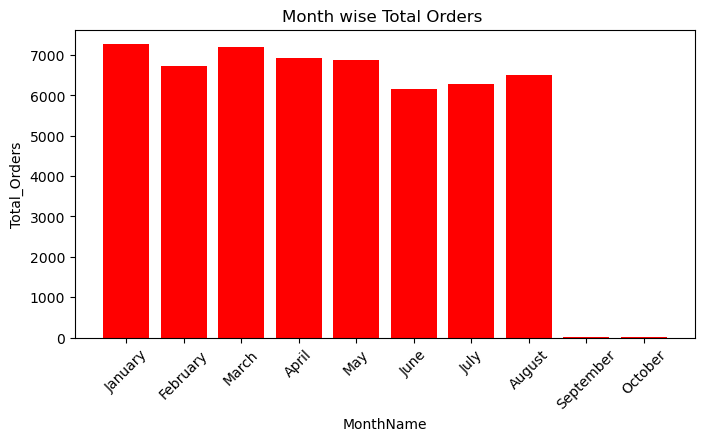

In [53]:
query="""select month(order_purchase_timestamp) as `Month` ,monthname(order_purchase_timestamp) as `MonthName`,count(order_id) as Total_Orders 
from orders 
where year(order_purchase_timestamp) = 2018 
group by month(order_purchase_timestamp),monthname(order_purchase_timestamp)
order by month(order_purchase_timestamp)   """
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["MonthNumber","MonthName","Total_Orders"])

plt.figure(figsize = (8,4))
ax=plt.bar(df["MonthName"],df["Total_Orders"],color="red")

plt.xticks(rotation = 45)
plt.xlabel("MonthName")
plt.ylabel("Total_Orders")
plt.title("Month wise Total Orders ")
plt.show()

#  Calculate the percentage of total revenue contributed by each product category.

In [70]:
query="""select  p.product_category ,round(sum(py.payment_value),2)  as category_revenue,
      round(
        (sum(py.payment_value) / 
        (select sum(payment_value) from payments)) * 100, 2
    ) as  revenue_percentage
from products p  join order_items oi on p.product_id=oi.product_id
join payments py on py.order_id=oi.order_id 
group  by  p.product_category
order by  revenue_percentage desc """
cur.execute(query)
data=cur.fetchall()
data


df=pd.DataFrame(data,columns=["Product_Category","Total_Sales","Percentage_Of_Total_Sales"])
df.head()

,Product_Category,Total_Sales,Percentage_Of_Total_Sales
0,bed table bath,1712553.67,10.70
1,HEALTH BEAUTY,1657373.12,10.35
2,computer accessories,1585330.45,9.90
3,Furniture Decoration,1430176.39,8.93
4,Watches present,1429216.68,8.93


# Calculate the total revenue generated by each seller, and rank them by revenue.

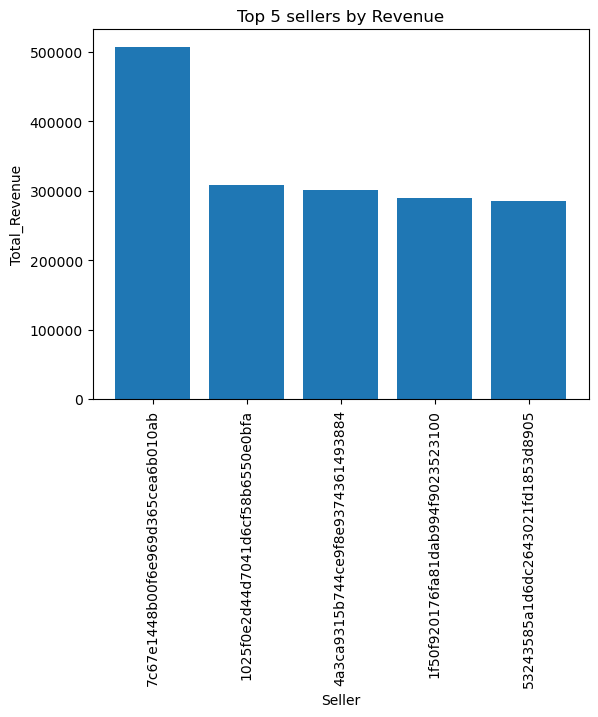

In [83]:
query="""select * from (select s.seller_id ,sum(p.payment_value) as Total_Revenue, Rank() over(order by sum(p.payment_value)  desc ) rn 
from sellers s join order_items oi  on s.seller_id=oi.seller_id 
join payments p on oi.order_id=p.order_id 
group by s.seller_id) as t1 where rn<=5 """
cur.execute(query)
data=cur.fetchall()
data


df=pd.DataFrame(data,columns=["seller","Total_Revenue","Rank"])
df.head()

plt.bar(df["seller"], df["Total_Revenue"])
plt.xticks(rotation = 90)
plt.xlabel("Seller")
plt.ylabel("Total_Revenue")
plt.title("Top 5 sellers by Revenue")
plt.show()

# Calculate the year-over-year growth rate of total sales.

In [91]:
import numpy as np 
query="""select year(o.order_purchase_timestamp),
round(((sum(p.payment_value)-lag(sum(p.payment_value)) over(order by year(o.order_purchase_timestamp)))/lag(sum(p.payment_value)) over(order by year(o.order_purchase_timestamp)))*100,4)  as `%Revenue Growth`
from orders o   join payments p on o.order_id=p.order_id 
group by year(o.order_purchase_timestamp)
order by year(o.order_purchase_timestamp) asc  """
cur.execute(query)
data=cur.fetchall()
data


df=pd.DataFrame(data,columns=["Year","%Growth"])

df["%Growth"] = df["%Growth"].replace(np.nan, 0.0)
df



,Year,%Growth
0,2016,0.0000
1,2017,12112.7038
2,2018,20.0009


#  Calculate the cumulative sales per month for each year.

In [94]:
query=""" 
select year(o.order_purchase_timestamp) as Year , month(o.order_purchase_timestamp) as Month ,sum(p.payment_value) as Sales ,
   sum(sum(p.payment_value)) over(partition by year(o.order_purchase_timestamp) order by month(o.order_purchase_timestamp) ) as Cumulative_Sales 
from orders  o join payments p on o.order_id=p.order_id
group by year(o.order_purchase_timestamp) , month(o.order_purchase_timestamp)
order by year(o.order_purchase_timestamp)  asc , month(o.order_purchase_timestamp)

"""

cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["Year","Month","Sales","Cumulative_Sales"])
df

,Year,Month,Sales,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,138488.04
4,2017,2,291908.01,430396.05
5,2017,3,449863.60,880259.65
6,2017,4,417788.03,1298047.68
7,2017,5,592918.82,1890966.50
8,2017,6,511276.38,2402242.88
9,2017,7,592382.92,2994625.80


#  Identify the top 3 customers who spent the most money in each year.

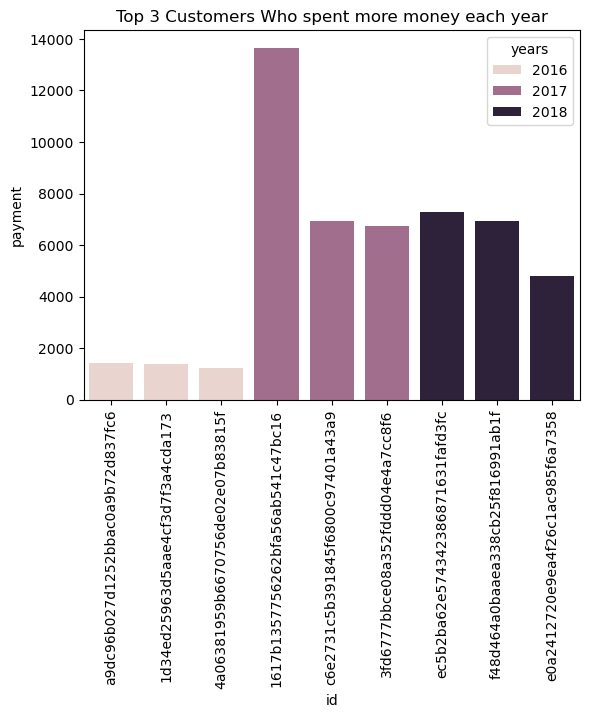

In [101]:
query=""" 
select *  from (
select year(o.order_purchase_timestamp) as yr ,o.customer_id as cus, sum(p.payment_value)   as spent ,
   dense_Rank() over(partition by year(o.order_purchase_timestamp) order by  sum(p.payment_value) desc ) as rn 
from orders  o join payments p on o.order_id=p.order_id 
group by year(o.order_purchase_timestamp) ,o.customer_id
order by yr  asc ) as t1 
where rn <= 3

""" 
cur.execute(query)
data=cur.fetchall()
data



df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.title("Top 3 Customers Who spent more money each year")
plt.show()

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [106]:
query = """ 
select 100.0 * sum(case 
                when second_purchase is not null  
                 and  second_purchase <= DATE_ADD(first_purchase, interval 6 month )
                then 1 else 0 end 
              ) / count(*) as retention_rate_percent
              from (
select  id ,max(case when rn=1 then purchase_date end  ) as first_purchase,
             max(case when rn=2 then purchase_date end  ) as second_purchase
from (
select  customer_id as id  ,date(order_purchase_timestamp) as purchase_date,
row_number() over(partition by customer_id order by order_purchase_timestamp) as rn 
from orders)  as t1 
group by id) t2 
;

""" 
cur.execute(query)
data=cur.fetchall()
data

df=pd.Series(data)
df

0    (0.00000,)
dtype: object

# Customer Purchasing Power Index

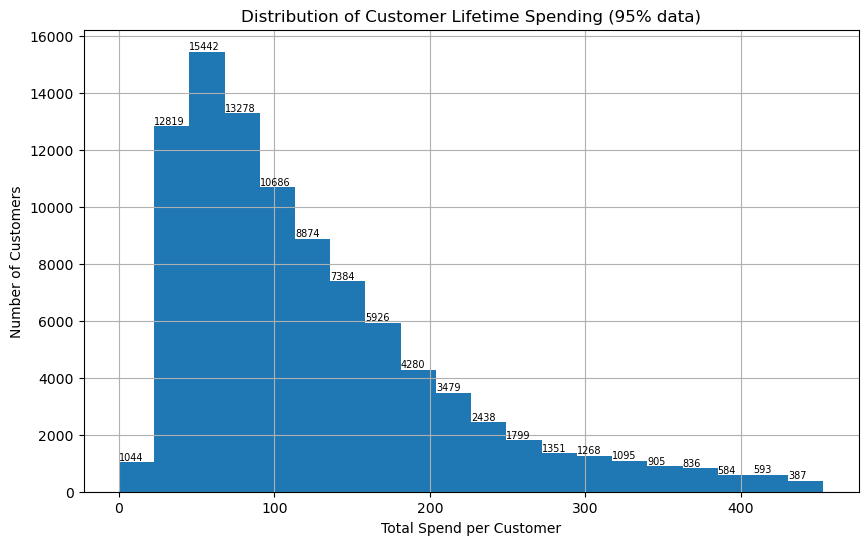

In [122]:
query = """ 
SELECT 
    customer_id,
    SUM(payment_value) AS total_spent
FROM orders o
JOIN payments p ON o.order_id = p.order_id
GROUP BY customer_id;

"""
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["Customer_id","Total_Spend"])

filtered = df[df["Total_Spend"] < df["Total_Spend"].quantile(0.95)]

plt.figure(figsize=(10,6))

# Store histogram results
counts, bins, patches = plt.hist(filtered["Total_Spend"], bins=20)

plt.xlabel("Total Spend per Customer")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Lifetime Spending (95% data)")
plt.grid(True)

# --- Add labels on bars ---
for count, bin_edge in zip(counts, bins):
    if count > 0: 
        plt.text(bin_edge, count, str(int(count)),
                 rotation=360,
                 va='bottom',
                 fontsize=7)



plt.show()


# Product Demand Seasonality Index

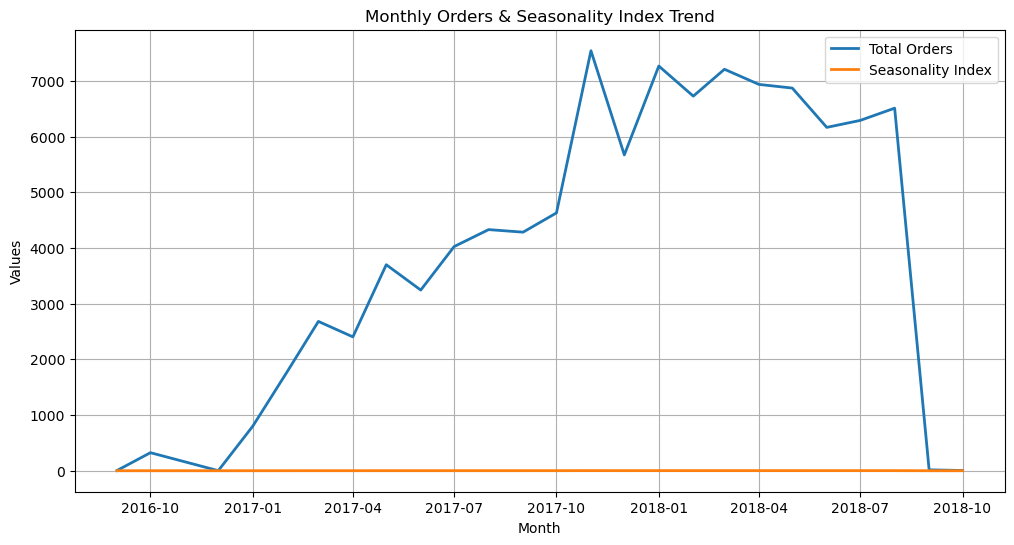

In [125]:
query = """ 
WITH monthly_orders AS (
    SELECT 
        DATE_FORMAT(order_purchase_timestamp, '%Y-%m') AS month,
        COUNT(*) AS total_orders
    FROM orders
    GROUP BY DATE_FORMAT(order_purchase_timestamp, '%Y-%m')
),
stats AS (
    SELECT 
        month,
        total_orders,
        AVG(total_orders) OVER () AS overall_avg
    FROM monthly_orders
)
SELECT 
    month,
    total_orders,
    total_orders / overall_avg AS seasonality_index
FROM stats
ORDER BY month;


""" 
cur.execute(query)
data=cur.fetchall()



df = pd.DataFrame(data, columns=["Month", "Total_Orders", "Seasonality_Index"])


df["Month"] = pd.to_datetime(df["Month"])



plt.figure(figsize=(12,6))

plt.plot(df["Month"], df["Total_Orders"], label="Total Orders", linewidth=2)
plt.plot(df["Month"], df["Seasonality_Index"], label="Seasonality Index", linewidth=2)

plt.xlabel("Month")
plt.ylabel("Values")
plt.title("Monthly Orders & Seasonality Index Trend")
plt.legend()
plt.grid(True)

plt.show()

# Customer Lifetime Value vs Order Frequency

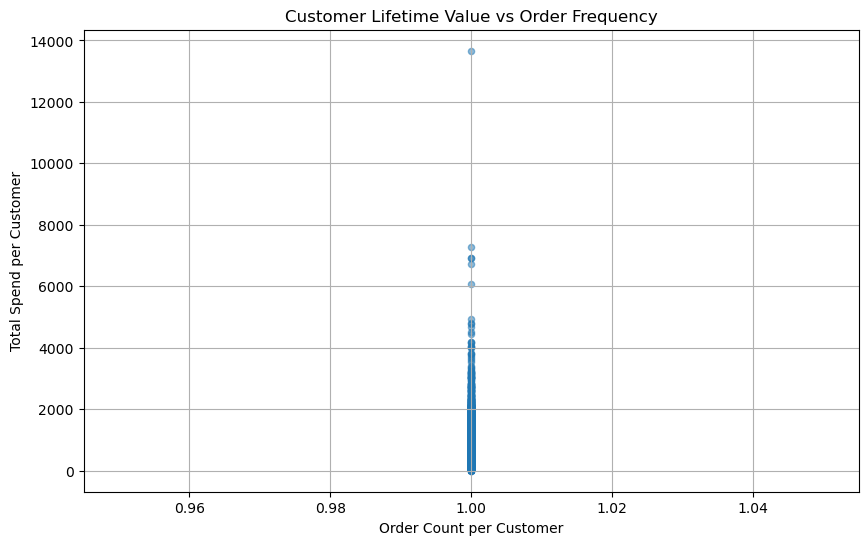

In [126]:

query = """ 
WITH customer_spend AS (
    SELECT customer_id, SUM(payment_value) AS total_spend
    FROM payments
    JOIN orders USING(order_id)
    GROUP BY customer_id
),
customer_freq AS (
    SELECT customer_id, COUNT(order_id) AS order_count
    FROM orders
    GROUP BY customer_id
)
SELECT 
    s.customer_id,
    s.total_spend,
    f.order_count
FROM customer_spend s
JOIN customer_freq f USING(customer_id);
"""

cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["Customer_ID", "Total_Spend", "Order_Count"])


import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.scatter(
    df["Order_Count"], 
    df["Total_Spend"], 
    alpha=0.5,       
    s=20             
)

plt.xlabel("Order Count per Customer")
plt.ylabel("Total Spend per Customer")
plt.title("Customer Lifetime Value vs Order Frequency")
plt.grid(True)

plt.show()


# Seller Market Share Based on Revenue (TOP 10 Only)

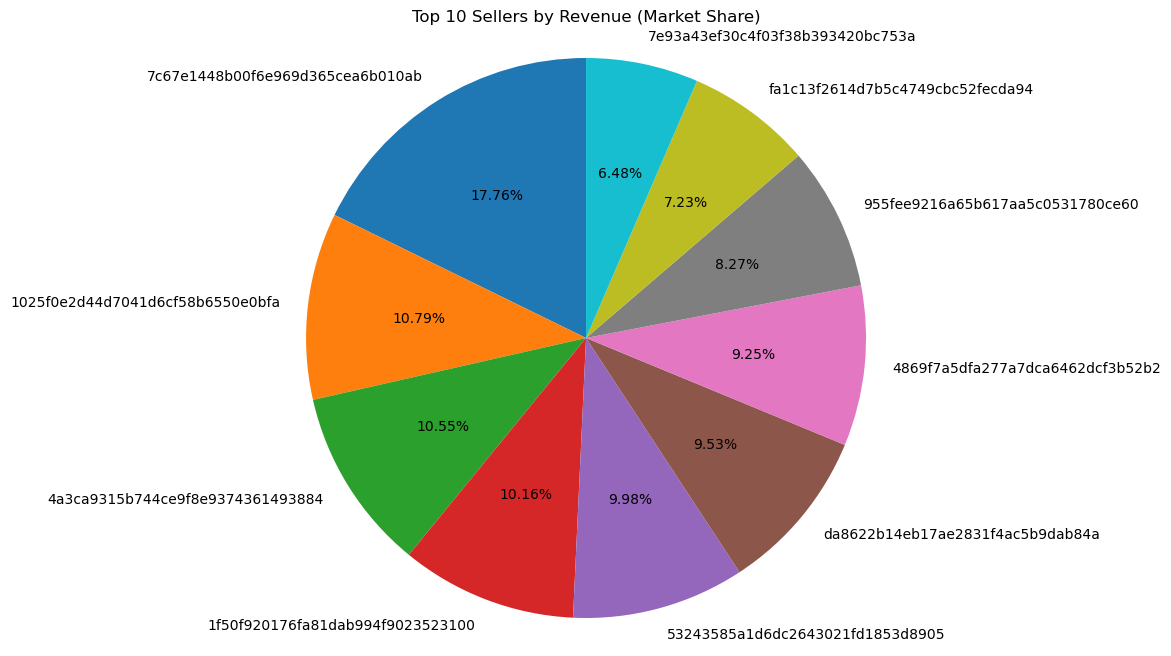

In [127]:

query = """
WITH seller_revenue AS (
    SELECT 
        oi.seller_id,
        SUM(p.payment_value) AS revenue
    FROM order_items oi
    JOIN payments p ON oi.order_id = p.order_id
    GROUP BY oi.seller_id
)
SELECT seller_id, revenue
FROM seller_revenue
ORDER BY revenue DESC
LIMIT 10;
"""

cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["Seller_ID", "Revenue"])


import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.pie(df["Revenue"], 
        labels=df["Seller_ID"], 
        autopct="%0.2f%%",
        startangle=90)

plt.title("Top 10 Sellers by Revenue (Market Share)")
plt.axis("equal")  
plt.show()
